# Medical Imaging & Big Data

## 1. Introduction, Libraries, Setups
[testo]

## Environment for using GPU (per Matteo)

Runna i codici in quest'ordine. Se hai installato TensorFlow sul base environment di Python, ti consiglio di fgare un virtual environment per non far casini fra PyTorch e TF. Io sono riuscito a usare python 3.12

1) scaricati e installa CUDA 12.1 (NO ALTRE VERSIONI) da qui https://developer.nvidia.com/cuda-12-1-0-download-archive
2) scaricati il pacchetto cuDDN 9.2.1 da qui https://developer.nvidia.com/cudnn-downloads?target_os=Windows&target_arch=x86_64&target_version=Agnostic&cuda_version=12
3) unzippa il cuDNN e inserisci i contenuti delle cartelle *lib*, *bin* e *include* nelle rispettive cartelle lib, bin e include del percorso "C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.1"
4) le variabili dovrebbero essere già tutte su PATH, in caso non lo fossero segui questa guida: https://medium.com/thesecmaster/step-by-step-guide-to-setup-pytorch-for-your-gpu-on-windows-10-11-524d58cf2744

In [1]:
#Per installare pytorch eccetera
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Per importare pytorch e verificare se è disponibile la GPU
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using", device, "device")

Using cuda device


In [ ]:
#Per impostare la GPU come default nel caso sopra non funzioni (fai uncomment)
#torch.set_default_device('cuda')

In [7]:
%pip install setuptools

   ---------------------------------------- 0.0/930.8 kB ? eta -:--:--
   --------------------------------------- 930.8/930.8 kB 29.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install pydicom numpy matplotlib pandas gdcm opencv-python scikit-image scikit-learn tqdm
%pip install tabulate #questo serve per le taballe di comparazione
#!conda install -c conda-forge gdcm -y

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#questo': Expected package name at the start of dependency specifier
    #questo
    ^


## 2. Dataset Preprocessing

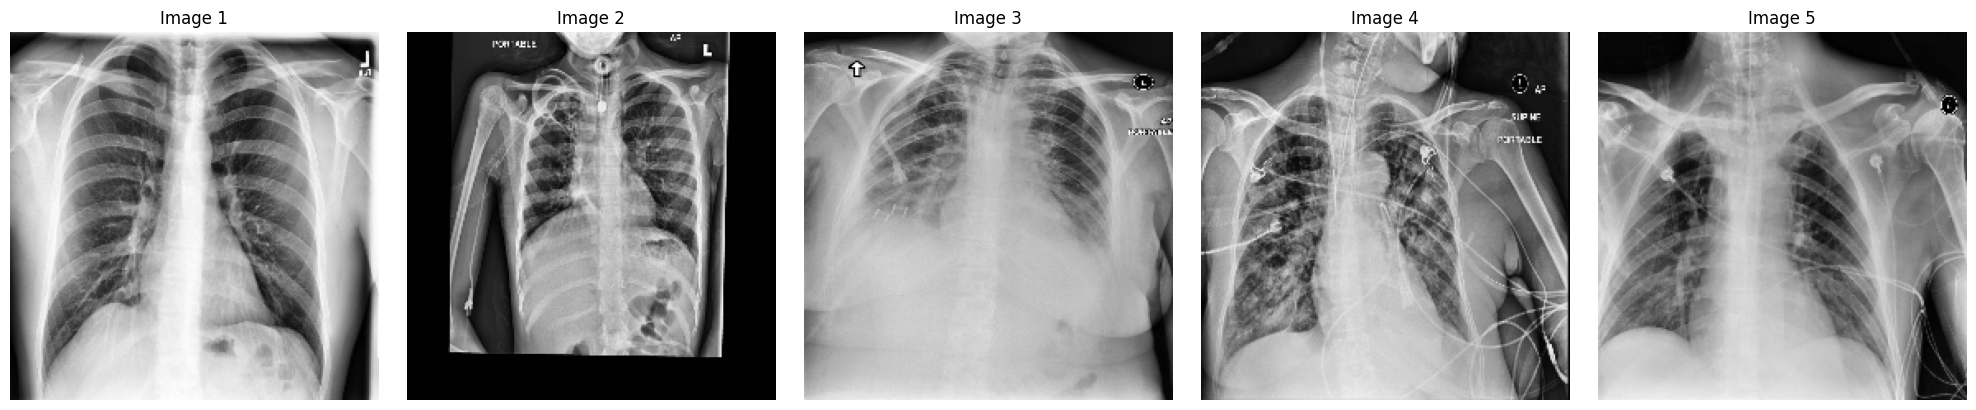

Total number of images: 10719
Preprocessed image shape: torch.Size([5, 1, 224, 224])


In [1]:
import os
import numpy as np
import pydicom
import cv2
from skimage import exposure
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

def preprocess_dicom(dicom_path):
    """
    Preprocess a single DICOM image.
    Steps:
    1. Read DICOM file
    2. Extract pixel array
    3. Normalize pixel values
    4. Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    5. Resize image to a standard size
    6. Convert to PyTorch tensor
    """
    # Read DICOM file
    dicom = pydicom.dcmread(dicom_path)
    
    # Extract pixel array and convert to float
    image = dicom.pixel_array.astype(np.float32)
    
    # Normalize pixel values to [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply((image * 255).astype(np.uint8))
    
    # Resize image to a standard size (e.g., 224x224 for many CNN architectures)
    image = cv2.resize(image, (224, 224))
    
    # Convert to PyTorch tensor
    image_tensor = transforms.ToTensor()(image)
    
    return image_tensor

class DicomDataset(Dataset):
    """
    Custom Dataset class for DICOM images.
    """
    def __init__(self, dicom_dir):
        self.dicom_files = [os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if f.endswith('.dcm')]

    def __len__(self):
        return len(self.dicom_files)

    def __getitem__(self, idx):
        return preprocess_dicom(self.dicom_files[idx])

# Set up the dataset and dataloader
dicom_dir = "dicom_files"
dataset = DicomDataset(dicom_dir)
dataloader = DataLoader(dataset, batch_size=5, shuffle=False)

# Get the first 5 preprocessed images
first_batch = next(iter(dataloader))

# Display the first 5 preprocessed images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, img in enumerate(first_batch):
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}")
plt.tight_layout()
plt.show()

print(f"Total number of images: {len(dataset)}")
print(f"Preprocessed image shape: {first_batch.shape}")

## 3. Metadata Extraction and Exploration


In [2]:
import os
import pydicom
import pandas as pd

def extract_metadata(dicom_dir):
    metadata_list = []
    for filename in os.listdir(dicom_dir):
        if filename.endswith('.dcm'):
            dicom_path = os.path.join(dicom_dir, filename)
            dicom = pydicom.dcmread(dicom_path)
            metadata = {
                'filename': filename,
                'PatientID': dicom.get('PatientID', ''),
                'PatientAge': dicom.get('PatientAge', ''),
                'PatientSex': dicom.get('PatientSex', ''),
                'PatientWeight': dicom.get('PatientWeight', ''),
                'StudyDate': dicom.get('StudyDate', ''),
                'Modality': dicom.get('Modality', ''),
                'BodyPartExamined': dicom.get('BodyPartExamined', '')
            }
            metadata_list.append(metadata)
    
    return pd.DataFrame(metadata_list)

# Extract metadata
dicom_dir = "dicom_files"
metadata_df = extract_metadata(dicom_dir)

# Save to CSV
metadata_df.to_csv('dicom_metadata.csv', index=False)

# Display the first five rows
print(metadata_df.head())

                                            filename  \
0  1.2.276.0.7230010.3.1.4.8323329.1000.151787516...   
1  1.2.276.0.7230010.3.1.4.8323329.10000.15178752...   
2  1.2.276.0.7230010.3.1.4.8323329.10001.15178752...   
3  1.2.276.0.7230010.3.1.4.8323329.10002.15178752...   
4  1.2.276.0.7230010.3.1.4.8323329.10003.15178752...   

                              PatientID PatientAge PatientSex PatientWeight  \
0  17d405a3-a0d2-4901-b33a-63906aa48d9f         38          M                 
1  8ab1ffda-8b65-4914-95d6-2e549e328666         10          F                 
2  bfef51d3-6541-4792-bac1-d21d41ee60fd         50          F                 
3  d19d956f-4ddd-4688-81ff-909c85e0e2d9         68          F                 
4  cf71a760-f693-4ccf-acd4-a41ff4845a5f         65          M                 

  StudyDate Modality BodyPartExamined  
0  19010101       CR            CHEST  
1  19010101       CR            CHEST  
2  19010101       CR            CHEST  
3  19010101       CR        

In [3]:
import torch
import time

def test_cuda():
    print(f"CUDA is available: {torch.cuda.is_available()}")
    print(f"CUDA device count: {torch.cuda.device_count()}")
    if torch.cuda.is_available():
        print(f"Current CUDA device: {torch.cuda.current_device()}")
        print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

    # Larger matrix size
    sizes = [1000, 5000, 10000]

    for size in sizes:
        print(f"\nTesting with matrix size: {size}x{size}")
        x = torch.randn(size, size)

        # Warm-up GPU
        if torch.cuda.is_available():
            warm_up = torch.randn(1000, 1000).cuda()
            warm_up_result = warm_up.matmul(warm_up)
            del warm_up, warm_up_result
            torch.cuda.empty_cache()

        # Time CPU operation
        start_time = time.time()
        cpu_result = x.matmul(x)
        cpu_time = time.time() - start_time
        print(f"CPU time: {cpu_time:.4f} seconds")

        # Time GPU operation
        if torch.cuda.is_available():
            x_gpu = x.cuda()
            torch.cuda.synchronize()
            start_time = time.time()
            gpu_result = x_gpu.matmul(x_gpu)
            torch.cuda.synchronize()
            gpu_time = time.time() - start_time
            print(f"GPU time: {gpu_time:.4f} seconds")
            del x_gpu, gpu_result
            torch.cuda.empty_cache()
        else:
            print("CUDA is not available, skipping GPU test.")

        del x, cpu_result

if __name__ == "__main__":
    test_cuda()

CUDA is available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 4070 Ti

Testing with matrix size: 1000x1000
CPU time: 0.0179 seconds
GPU time: 0.0000 seconds

Testing with matrix size: 5000x5000
CPU time: 0.3713 seconds
GPU time: 0.0201 seconds

Testing with matrix size: 10000x10000
CPU time: 2.8763 seconds
GPU time: 0.0815 seconds


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pydicom
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import time

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# DICOM Dataset
class DicomDataset(Dataset):
    def __init__(self, dicom_dir, metadata, transform=None):
        self.dicom_dir = dicom_dir
        self.metadata = metadata
        self.transform = transform
        self.file_list = metadata['filename'].tolist()

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        try:
            filename = self.file_list[idx]
            dicom_path = os.path.join(self.dicom_dir, filename)
            
            dicom = pydicom.dcmread(dicom_path, force=True)
            image = dicom.pixel_array.astype(np.float32)
            image = (image - image.min()) / (image.max() - image.min())
            
            if self.transform:
                image = self.transform(image)
            
            label = 1 if self.metadata.iloc[idx]['PatientSex'] == 'M' else 0
            
            return image, label
        except Exception as e:
            print(f"Error loading DICOM file {filename}: {str(e)}")
            return None

# Model 1: Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        
        start_time = time.time()
        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            if batch_idx == 0:
                print(f"Batch shape: {images.shape}")
                print(f"First batch loaded in {time.time() - start_time:.2f} seconds")
            
            images, labels = images.to(device), labels.float().to(device)
            
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            train_correct += ((outputs > 0.5) == labels).sum().item()
            
            if batch_idx == 0:
                print(f"First batch processed in {time.time() - start_time:.2f} seconds")
        
        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Epoch completed in {time.time() - start_time:.2f} seconds")
        print()
    
    return train_acc

# Main execution
def main():
    # Load and preprocess data
    metadata_df = pd.read_csv('dicom_metadata.csv')
    print(f"Total samples in metadata: {len(metadata_df)}")
    
    # Split data
    train_df, val_df = train_test_split(metadata_df, test_size=0.2, random_state=42)
    print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")
    
    # Create datasets and dataloaders
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])
    
    train_dataset = DicomDataset("dicom_files", train_df, transform=transform)
    val_dataset = DicomDataset("dicom_files", val_df, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    print(f"Number of batches in train_loader: {len(train_loader)}")
    
    # Initialize model, loss function, and optimizer
    model = SimpleCNN()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    print("Starting training...")
    train_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)
    
    print(f"Final Training Accuracy: {train_acc:.4f}")

if __name__ == "__main__":
    main()

Using device: cuda
Total samples in metadata: 10719
Training samples: 8575, Validation samples: 2144
Number of batches in train_loader: 268
Starting training...


Epoch 1/5:   0%|          | 0/268 [00:00<?, ?it/s]

Batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.33 seconds


Epoch 1/5:   0%|          | 1/268 [00:00<03:43,  1.20it/s]

First batch processed in 0.84 seconds


Epoch 1/5: 100%|██████████| 268/268 [01:31<00:00,  2.93it/s]


Epoch 1/5
Train Loss: 0.6644, Train Acc: 0.6657
Epoch completed in 91.55 seconds



Epoch 2/5:   0%|          | 1/268 [00:00<01:29,  2.98it/s]

Batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.26 seconds
First batch processed in 0.34 seconds


Epoch 2/5: 100%|██████████| 268/268 [01:34<00:00,  2.85it/s]


Epoch 2/5
Train Loss: 0.4366, Train Acc: 0.7832
Epoch completed in 94.04 seconds



Epoch 3/5:   0%|          | 1/268 [00:00<01:33,  2.86it/s]

Batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.28 seconds
First batch processed in 0.35 seconds


Epoch 3/5: 100%|██████████| 268/268 [01:42<00:00,  2.61it/s]


Epoch 3/5
Train Loss: 0.3233, Train Acc: 0.8475
Epoch completed in 102.73 seconds



Epoch 4/5:   0%|          | 1/268 [00:00<01:34,  2.82it/s]

Batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.28 seconds
First batch processed in 0.36 seconds


Epoch 4/5: 100%|██████████| 268/268 [01:34<00:00,  2.82it/s]


Epoch 4/5
Train Loss: 0.2290, Train Acc: 0.9010
Epoch completed in 94.95 seconds



Epoch 5/5:   0%|          | 1/268 [00:00<01:26,  3.07it/s]

Batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.25 seconds
First batch processed in 0.33 seconds


Epoch 5/5: 100%|██████████| 268/268 [02:01<00:00,  2.21it/s]

Epoch 5/5
Train Loss: 0.1468, Train Acc: 0.9370
Epoch completed in 121.39 seconds

Final Training Accuracy: 0.9370


Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pydicom
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import time
from tabulate import tabulate

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# DICOM Dataset
class DicomDataset(Dataset):
    def __init__(self, dicom_dir, metadata, transform=None):
        self.dicom_dir = dicom_dir
        self.metadata = metadata
        self.transform = transform
        self.file_list = metadata['filename'].tolist()

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        try:
            filename = self.file_list[idx]
            dicom_path = os.path.join(self.dicom_dir, filename)
            
            dicom = pydicom.dcmread(dicom_path, force=True)
            image = dicom.pixel_array.astype(np.float32)
            image = (image - image.min()) / (image.max() - image.min())
            
            if self.transform:
                image = self.transform(image)
            
            label = 1 if self.metadata.iloc[idx]['PatientSex'] == 'M' else 0
            
            return image, label
        except Exception as e:
            print(f"Error loading DICOM file {filename}: {str(e)}")
            return None

# Model 1: Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Model 2: CheXNet-inspired (based on DenseNet121)
class CheXNetInspired(nn.Module):
    def __init__(self):
        super(CheXNetInspired, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        self.densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, 1)

    def forward(self, x):
        return self.densenet(x)

# Model 3: Simplified X-RayGAN-inspired (using a basic autoencoder structure)
class XRayGANInspired(nn.Module):
    def __init__(self):
        super(XRayGANInspired, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU()
        )
        # Decoder (not used for classification, but part of the X-RayGAN inspired architecture)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

# Model 4: CheXpert-inspired (using a ResNet18 backbone)
class CheXpertInspired(nn.Module):
    def __init__(self):
        super(CheXpertInspired, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 1)

    def forward(self, x):
        return self.resnet(x)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    model.to(device)
    best_val_acc = 0.0
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        
        start_time = time.time()
        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            if batch_idx == 0:
                print(f"First batch shape: {images.shape}")
                print(f"First batch loaded in {time.time() - start_time:.2f} seconds")
            
            images, labels = images.to(device), labels.float().to(device)
            
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            train_correct += ((outputs > 0.5) == labels).sum().item()
            
            if batch_idx == 0:
                print(f"First batch processed in {time.time() - start_time:.2f} seconds")
        
        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().to(device)
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                val_correct += ((outputs > 0.5) == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Epoch completed in {time.time() - start_time:.2f} seconds")
        print()
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
    
    return best_val_acc, best_val_loss

# Main execution
def main():
    # Load and preprocess data
    metadata_df = pd.read_csv('dicom_metadata.csv')
    print(f"Total samples in metadata: {len(metadata_df)}")
    
    # Split data
    train_df, val_df = train_test_split(metadata_df, test_size=0.2, random_state=42)
    print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")
    
    # Create datasets and dataloaders
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])
    
    train_dataset = DicomDataset("dicom_files", train_df, transform=transform)
    val_dataset = DicomDataset("dicom_files", val_df, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    print(f"Number of batches in train_loader: {len(train_loader)}")
    
    # Initialize models
    models = {
        "SimpleCNN": SimpleCNN(),
        "CheXNet-inspired": CheXNetInspired(),
        "X-RayGAN-inspired": XRayGANInspired(),
        "CheXpert-inspired": CheXpertInspired()
    }
    
    criterion = nn.BCEWithLogitsLoss()
    results = []
    
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        best_val_acc, best_val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)
        results.append([model_name, best_val_acc, best_val_loss])
    
    # Print final results as a table
    headers = ["Model", "Best Validation Accuracy", "Best Validation Loss"]
    print("\nFinal Results:")
    print(tabulate(results, headers=headers, floatfmt=".4f"))

if __name__ == "__main__":
    main()

c:\Users\alexc\OneDrive\Documenti\GitHub\Medical-Imaging-DS-Bicocca\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alexc\OneDrive\Documenti\GitHub\Medical-Imaging-DS-Bicocca\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Total samples in metadata: 10719
Training samples: 8575, Validation samples: 2144
Number of batches in train_loader: 268


c:\Users\alexc\OneDrive\Documenti\GitHub\Medical-Imaging-DS-Bicocca\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training SimpleCNN...


Epoch 1/5:   0%|          | 1/268 [00:00<01:37,  2.74it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.34 seconds
First batch processed in 0.37 seconds


Epoch 1/5: 100%|██████████| 268/268 [01:44<00:00,  2.56it/s]


Epoch 1/5
Train Loss: 0.6501, Train Acc: 0.6513
Val Loss: 0.4930, Val Acc: 0.7449
Epoch completed in 137.12 seconds



Epoch 2/5:   0%|          | 1/268 [00:00<01:30,  2.95it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.28 seconds
First batch processed in 0.34 seconds


Epoch 2/5: 100%|██████████| 268/268 [01:31<00:00,  2.92it/s]


Epoch 2/5
Train Loss: 0.4451, Train Acc: 0.7734
Val Loss: 0.4926, Val Acc: 0.6940
Epoch completed in 111.99 seconds



Epoch 3/5:   0%|          | 1/268 [00:00<01:15,  3.54it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.26 seconds
First batch processed in 0.28 seconds


Epoch 3/5: 100%|██████████| 268/268 [01:28<00:00,  3.04it/s]


Epoch 3/5
Train Loss: 0.3893, Train Acc: 0.8092
Val Loss: 0.3786, Val Acc: 0.7943
Epoch completed in 108.52 seconds



Epoch 4/5:   0%|          | 1/268 [00:00<01:19,  3.37it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.28 seconds
First batch processed in 0.30 seconds


Epoch 4/5: 100%|██████████| 268/268 [01:25<00:00,  3.12it/s]


Epoch 4/5
Train Loss: 0.2967, Train Acc: 0.8659
Val Loss: 0.3491, Val Acc: 0.8461
Epoch completed in 105.58 seconds



Epoch 5/5:   0%|          | 1/268 [00:00<01:28,  3.01it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.28 seconds
First batch processed in 0.33 seconds


Epoch 5/5: 100%|██████████| 268/268 [01:26<00:00,  3.11it/s]


Epoch 5/5
Train Loss: 0.2050, Train Acc: 0.9103
Val Loss: 0.4168, Val Acc: 0.8461
Epoch completed in 106.39 seconds


Training CheXNet-inspired...


Epoch 1/5:   0%|          | 0/268 [00:00<?, ?it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.29 seconds


Epoch 1/5:   0%|          | 1/268 [00:00<03:14,  1.37it/s]

First batch processed in 0.73 seconds


Epoch 1/5: 100%|██████████| 268/268 [01:37<00:00,  2.74it/s]


Epoch 1/5
Train Loss: 0.2806, Train Acc: 0.8688
Val Loss: 0.5225, Val Acc: 0.8410
Epoch completed in 120.50 seconds



Epoch 2/5:   0%|          | 0/268 [00:00<?, ?it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.28 seconds


Epoch 2/5:   0%|          | 1/268 [00:00<02:20,  1.90it/s]

First batch processed in 0.53 seconds


Epoch 2/5: 100%|██████████| 268/268 [01:37<00:00,  2.76it/s]


Epoch 2/5
Train Loss: 0.1799, Train Acc: 0.9248
Val Loss: 0.1674, Val Acc: 0.9268
Epoch completed in 119.73 seconds



Epoch 3/5:   0%|          | 0/268 [00:00<?, ?it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.27 seconds


Epoch 3/5:   0%|          | 1/268 [00:00<02:23,  1.87it/s]

First batch processed in 0.54 seconds


Epoch 3/5: 100%|██████████| 268/268 [01:36<00:00,  2.76it/s]


Epoch 3/5
Train Loss: 0.1310, Train Acc: 0.9471
Val Loss: 0.1557, Val Acc: 0.9384
Epoch completed in 119.49 seconds



Epoch 4/5:   0%|          | 1/268 [00:00<02:03,  2.16it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.26 seconds
First batch processed in 0.47 seconds


Epoch 4/5: 100%|██████████| 268/268 [01:37<00:00,  2.75it/s]


Epoch 4/5
Train Loss: 0.1150, Train Acc: 0.9527
Val Loss: 0.1460, Val Acc: 0.9412
Epoch completed in 120.53 seconds



Epoch 5/5:   0%|          | 0/268 [00:00<?, ?it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.29 seconds


Epoch 5/5:   0%|          | 1/268 [00:00<02:12,  2.02it/s]

First batch processed in 0.50 seconds


Epoch 5/5: 100%|██████████| 268/268 [01:37<00:00,  2.76it/s]


Epoch 5/5
Train Loss: 0.0982, Train Acc: 0.9591
Val Loss: 0.1884, Val Acc: 0.9347
Epoch completed in 120.31 seconds


Training X-RayGAN-inspired...


Epoch 1/5:   0%|          | 1/268 [00:00<01:21,  3.29it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.26 seconds
First batch processed in 0.31 seconds


Epoch 1/5: 100%|██████████| 268/268 [01:33<00:00,  2.85it/s]


Epoch 1/5
Train Loss: 0.5693, Train Acc: 0.6751
Val Loss: 0.4462, Val Acc: 0.7621
Epoch completed in 117.95 seconds



Epoch 2/5:   0%|          | 0/268 [00:00<?, ?it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.27 seconds


Epoch 2/5:   0%|          | 1/268 [00:00<02:23,  1.87it/s]

First batch processed in 0.54 seconds


Epoch 2/5: 100%|██████████| 268/268 [01:28<00:00,  3.03it/s]


Epoch 2/5
Train Loss: 0.4057, Train Acc: 0.7900
Val Loss: 0.3564, Val Acc: 0.8326
Epoch completed in 111.19 seconds



Epoch 3/5:   0%|          | 1/268 [00:00<01:09,  3.84it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.25 seconds
First batch processed in 0.26 seconds


Epoch 3/5: 100%|██████████| 268/268 [01:25<00:00,  3.14it/s]


Epoch 3/5
Train Loss: 0.3312, Train Acc: 0.8414
Val Loss: 0.3429, Val Acc: 0.8465
Epoch completed in 106.90 seconds



Epoch 4/5:   0%|          | 0/268 [00:00<?, ?it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.30 seconds


Epoch 4/5:   0%|          | 1/268 [00:00<02:37,  1.70it/s]

First batch processed in 0.59 seconds


Epoch 4/5: 100%|██████████| 268/268 [01:21<00:00,  3.29it/s]


Epoch 4/5
Train Loss: 0.2403, Train Acc: 0.8905
Val Loss: 0.3668, Val Acc: 0.8372
Epoch completed in 104.02 seconds



Epoch 5/5:   0%|          | 1/268 [00:00<01:41,  2.62it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.26 seconds
First batch processed in 0.38 seconds


Epoch 5/5: 100%|██████████| 268/268 [01:23<00:00,  3.23it/s]


Epoch 5/5
Train Loss: 0.1648, Train Acc: 0.9287
Val Loss: 0.3724, Val Acc: 0.8615
Epoch completed in 104.91 seconds


Training CheXpert-inspired...


Epoch 1/5:   0%|          | 0/268 [00:00<?, ?it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.30 seconds


Epoch 1/5:   0%|          | 1/268 [00:00<02:54,  1.53it/s]

First batch processed in 0.66 seconds


Epoch 1/5: 100%|██████████| 268/268 [01:27<00:00,  3.06it/s]


Epoch 1/5
Train Loss: 0.2954, Train Acc: 0.8650
Val Loss: 0.2530, Val Acc: 0.8806
Epoch completed in 108.11 seconds



Epoch 2/5:   0%|          | 1/268 [00:00<01:25,  3.11it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.25 seconds
First batch processed in 0.32 seconds


Epoch 2/5: 100%|██████████| 268/268 [01:27<00:00,  3.06it/s]


Epoch 2/5
Train Loss: 0.1689, Train Acc: 0.9251
Val Loss: 0.1636, Val Acc: 0.9207
Epoch completed in 108.50 seconds



Epoch 3/5:   0%|          | 0/268 [00:00<?, ?it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.26 seconds


Epoch 3/5:   0%|          | 1/268 [00:00<02:29,  1.78it/s]

First batch processed in 0.56 seconds


Epoch 3/5: 100%|██████████| 268/268 [01:27<00:00,  3.07it/s]


Epoch 3/5
Train Loss: 0.1326, Train Acc: 0.9446
Val Loss: 0.1730, Val Acc: 0.9076
Epoch completed in 107.60 seconds



Epoch 4/5:   0%|          | 1/268 [00:00<01:15,  3.54it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.26 seconds
First batch processed in 0.28 seconds


Epoch 4/5: 100%|██████████| 268/268 [01:28<00:00,  3.04it/s]


Epoch 4/5
Train Loss: 0.1009, Train Acc: 0.9580
Val Loss: 0.1764, Val Acc: 0.9412
Epoch completed in 109.35 seconds



Epoch 5/5:   0%|          | 0/268 [00:00<?, ?it/s]

First batch shape: torch.Size([32, 1, 224, 224])
First batch loaded in 0.27 seconds


Epoch 5/5:   0%|          | 1/268 [00:00<02:22,  1.88it/s]

First batch processed in 0.53 seconds


Epoch 5/5: 100%|██████████| 268/268 [01:26<00:00,  3.09it/s]


Epoch 5/5
Train Loss: 0.0913, Train Acc: 0.9624
Val Loss: 0.2490, Val Acc: 0.9151
Epoch completed in 107.93 seconds


Final Results:
Model                Best Validation Accuracy    Best Validation Loss
-----------------  --------------------------  ----------------------
SimpleCNN                              0.8461                  0.3491
CheXNet-inspired                       0.9412                  0.1460
X-RayGAN-inspired                      0.8615                  0.3724
CheXpert-inspired                      0.9412                  0.1764


## Disease Prediction

In [22]:
import pandas as pd
import pydicom
import numpy as np
import os
from tqdm import tqdm

def create_pneumothorax_dataframe(csv_path, dicom_folder):
    # Read the CSV file
    df = pd.read_csv(csv_path)
    print(f"CSV file loaded. Shape: {df.shape}")

    # Initialize lists to store metadata and images
    metadata = []
    images = []
    labels = []

    # Iterate through each row in the DataFrame
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing DICOM files"):
        image_id = row['ImageId']
        encoded_pixels = row['EncodedPixels']
        
        # Add .dcm extension if it's not already there
        if not image_id.lower().endswith('.dcm'):
            image_id += '.dcm'
        
        dicom_path = os.path.join(dicom_folder, image_id)
        
        try:
            # Read DICOM file
            dicom = pydicom.dcmread(dicom_path)
            
            # Extract metadata
            meta = {attr: getattr(dicom, attr) for attr in dicom.dir() if attr != 'PixelData'}
            metadata.append(meta)
            
            # Extract image
            image = dicom.pixel_array.astype(np.float32)
            images.append(image)
            
            # Create label
            # Ensure we're comparing strings and accounting for potential whitespace
            label = 'no_pneumo' if str(encoded_pixels).strip() == '-1' else 'has_pneumo'
            labels.append(label)
            
        except Exception as e:
            print(f"Error processing {image_id}: {str(e)}")

    # Create DataFrame with metadata
    meta_df = pd.DataFrame(metadata)
    
    # Add image and label columns
    meta_df['Image'] = images
    meta_df['PneumothoraxLabel'] = labels

    return meta_df

# Usage
csv_path = 'train-rle.csv'
dicom_folder = 'dicom_files'

# Create the dataframe
full_df = create_pneumothorax_dataframe(csv_path, dicom_folder)

# Print information about the resulting dataframe
print("\nFull DataFrame created.")
print(f"Shape: {full_df.shape}")
print("\nColumns:")
print(full_df.columns.tolist())
print("\nSample of non-image columns:")
print(full_df.drop('Image', axis=1).head())
print("\nPneumothorax label distribution:")
print(full_df['PneumothoraxLabel'].value_counts(normalize=True))

# Optionally, save the dataframe (without images) to a CSV file
full_df.drop('Image', axis=1).to_csv('pneumothorax_full_metadata.csv', index=False)
print("\nMetadata (excluding images) saved to 'pneumothorax_full_metadata.csv'")

# Note: The full dataframe with images is kept in memory as 'full_df'

CSV file loaded. Shape: (11582, 2)


Processing DICOM files: 100%|██████████| 11582/11582 [01:12<00:00, 158.91it/s]



Full DataFrame created.
Shape: (11582, 36)

Columns:
['AccessionNumber', 'BitsAllocated', 'BitsStored', 'BodyPartExamined', 'Columns', 'ConversionType', 'HighBit', 'InstanceNumber', 'LossyImageCompression', 'LossyImageCompressionMethod', 'Modality', 'PatientAge', 'PatientBirthDate', 'PatientID', 'PatientName', 'PatientOrientation', 'PatientSex', 'PhotometricInterpretation', 'PixelRepresentation', 'PixelSpacing', 'ReferringPhysicianName', 'Rows', 'SOPClassUID', 'SOPInstanceUID', 'SamplesPerPixel', 'SeriesDescription', 'SeriesInstanceUID', 'SeriesNumber', 'SpecificCharacterSet', 'StudyDate', 'StudyID', 'StudyInstanceUID', 'StudyTime', 'ViewPosition', 'Image', 'PneumothoraxLabel']

Sample of non-image columns:
  AccessionNumber  BitsAllocated  BitsStored BodyPartExamined  Columns  \
0                              8           8            CHEST     1024   
1                              8           8            CHEST     1024   
2                              8           8            CHES

<Axes: title={'center': 'Pneumothorax Label Distribution'}, xlabel='PneumothoraxLabel'>

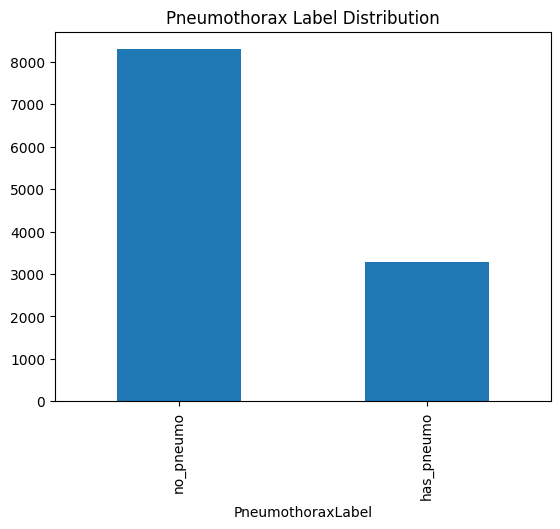

In [23]:
full_df.PneumothoraxLabel.value_counts().plot(kind='bar', title='Pneumothorax Label Distribution')

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm
import time

# Assuming full_df is your prepared DataFrame from the previous step

class PneumothoraxDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]['Image']
        label = 1 if self.dataframe.iloc[idx]['PneumothoraxLabel'] == 'has_pneumo' else 0

        if self.transform:
            image = self.transform(image)

        return image, label

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CheXNetInspired(nn.Module):
    def __init__(self):
        super(CheXNetInspired, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        self.densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, 2)

    def forward(self, x):
        return self.densenet(x)

class XRayGANInspired(nn.Module):
    def __init__(self):
        super(XRayGANInspired, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

class CheXpertInspired(nn.Module):
    def __init__(self):
        super(CheXpertInspired, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 2)

    def forward(self, x):
        return self.resnet(x)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        start_time = time.time()
        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            if batch_idx == 0:
                print(f"First batch shape: {images.shape}")
                print(f"First batch loaded in {time.time() - start_time:.2f} seconds")
            
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            if batch_idx == 0:
                print(f"First batch processed in {time.time() - start_time:.2f} seconds")
        
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
        print(f"Epoch completed in {time.time() - start_time:.2f} seconds")
        print()
    
    return val_acc, precision, recall, f1

# Prepare the data
train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

train_dataset = PneumothoraxDataset(train_df, transform=transform)
val_dataset = PneumothoraxDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

# Define models
models = {
    "SimpleCNN": SimpleCNN(),
    "CheXNet-inspired": CheXNetInspired(),
    "X-RayGAN-inspired": XRayGANInspired(),
    "CheXpert-inspired": CheXpertInspired()
}

# Train and evaluate models
results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    val_acc, precision, recall, f1 = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)
    results[model_name] = {"Accuracy": val_acc, "Precision": precision, "Recall": recall, "F1-score": f1}

# Print final results
print("\nFinal Results:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

c:\Users\alexc\OneDrive\Documenti\GitHub\Medical-Imaging-DS-Bicocca\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alexc\OneDrive\Documenti\GitHub\Medical-Imaging-DS-Bicocca\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\alexc\OneDrive\Documenti\GitHub\Medical-Imaging-DS-Bicocca\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The curre


Training SimpleCNN...


Epoch 1/5:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.17 seconds


Epoch 1/5:   0%|          | 2/580 [00:00<02:43,  3.55it/s]

First batch processed in 0.44 seconds


Epoch 1/5: 100%|██████████| 580/580 [02:13<00:00,  4.35it/s]


Epoch 1/5
Train Loss: 0.6001, Train Acc: 0.7159
Val Loss: 0.5768, Val Acc: 0.7078
Precision: 0.6918, Recall: 0.7078, F1-score: 0.5958
Epoch completed in 169.15 seconds



Epoch 2/5:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.17 seconds


Epoch 2/5:   0%|          | 1/580 [00:00<02:49,  3.41it/s]

First batch processed in 0.30 seconds


Epoch 2/5: 100%|██████████| 580/580 [02:34<00:00,  3.74it/s]


Epoch 2/5
Train Loss: 0.5568, Train Acc: 0.7201
Val Loss: 0.6639, Val Acc: 0.7082
Precision: 0.6686, Recall: 0.7082, F1-score: 0.6100
Epoch completed in 188.03 seconds



Epoch 3/5:   0%|          | 1/580 [00:00<01:37,  5.97it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.15 seconds
First batch processed in 0.17 seconds


Epoch 3/5: 100%|██████████| 580/580 [02:28<00:00,  3.90it/s]


Epoch 3/5
Train Loss: 0.5480, Train Acc: 0.7287
Val Loss: 0.5581, Val Acc: 0.7203
Precision: 0.6909, Recall: 0.7203, F1-score: 0.6605
Epoch completed in 183.15 seconds



Epoch 4/5:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.17 seconds


Epoch 4/5:   0%|          | 2/580 [00:00<02:29,  3.86it/s]

First batch processed in 0.41 seconds


Epoch 4/5: 100%|██████████| 580/580 [02:27<00:00,  3.93it/s]


Epoch 4/5
Train Loss: 0.5217, Train Acc: 0.7439
Val Loss: 0.5944, Val Acc: 0.7303
Precision: 0.7236, Recall: 0.7303, F1-score: 0.6617
Epoch completed in 183.86 seconds



Epoch 5/5:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.15 seconds


Epoch 5/5:   0%|          | 2/580 [00:00<02:48,  3.43it/s]

First batch processed in 0.51 seconds


Epoch 5/5: 100%|██████████| 580/580 [02:30<00:00,  3.86it/s]


Epoch 5/5
Train Loss: 0.4905, Train Acc: 0.7650
Val Loss: 0.5224, Val Acc: 0.7410
Precision: 0.7209, Recall: 0.7410, F1-score: 0.7079
Epoch completed in 184.05 seconds


Training CheXNet-inspired...


Epoch 1/5:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.15 seconds


Epoch 1/5:   0%|          | 1/580 [00:00<05:59,  1.61it/s]

First batch processed in 0.63 seconds


Epoch 1/5: 100%|██████████| 580/580 [02:31<00:00,  3.82it/s]


Epoch 1/5
Train Loss: 0.5734, Train Acc: 0.7201
Val Loss: 0.5642, Val Acc: 0.6914
Precision: 0.6359, Recall: 0.6914, F1-score: 0.6347
Epoch completed in 187.46 seconds



Epoch 2/5:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.17 seconds


Epoch 2/5:   0%|          | 1/580 [00:00<03:57,  2.44it/s]

First batch processed in 0.42 seconds


Epoch 2/5: 100%|██████████| 580/580 [02:36<00:00,  3.72it/s]


Epoch 2/5
Train Loss: 0.5355, Train Acc: 0.7396
Val Loss: 1.3133, Val Acc: 0.7190
Precision: 0.7090, Recall: 0.7190, F1-score: 0.6331
Epoch completed in 194.57 seconds



Epoch 3/5:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.18 seconds


Epoch 3/5:   0%|          | 1/580 [00:00<04:02,  2.39it/s]

First batch processed in 0.43 seconds


Epoch 3/5: 100%|██████████| 580/580 [02:34<00:00,  3.75it/s]


Epoch 3/5
Train Loss: 0.4980, Train Acc: 0.7605
Val Loss: 0.5765, Val Acc: 0.7497
Precision: 0.7335, Recall: 0.7497, F1-score: 0.7177
Epoch completed in 192.74 seconds



Epoch 4/5:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.14 seconds


Epoch 4/5:   0%|          | 1/580 [00:00<03:06,  3.10it/s]

First batch processed in 0.33 seconds


Epoch 4/5: 100%|██████████| 580/580 [02:33<00:00,  3.78it/s]


Epoch 4/5
Train Loss: 0.4708, Train Acc: 0.7764
Val Loss: 0.5108, Val Acc: 0.7380
Precision: 0.7666, Recall: 0.7380, F1-score: 0.7464
Epoch completed in 191.15 seconds



Epoch 5/5:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.16 seconds


Epoch 5/5:   0%|          | 1/580 [00:00<03:52,  2.49it/s]

First batch processed in 0.41 seconds


Epoch 5/5: 100%|██████████| 580/580 [02:36<00:00,  3.72it/s]


Epoch 5/5
Train Loss: 0.4551, Train Acc: 0.7852
Val Loss: 0.4711, Val Acc: 0.7881
Precision: 0.7995, Recall: 0.7881, F1-score: 0.7921
Epoch completed in 193.35 seconds


Training X-RayGAN-inspired...


Epoch 1/5:   0%|          | 1/580 [00:00<02:51,  3.39it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.15 seconds
First batch processed in 0.30 seconds


Epoch 1/5: 100%|██████████| 580/580 [02:20<00:00,  4.14it/s]


Epoch 1/5
Train Loss: 0.5833, Train Acc: 0.7170
Val Loss: 0.5868, Val Acc: 0.6953
Precision: 0.6689, Recall: 0.6953, F1-score: 0.6752
Epoch completed in 178.61 seconds



Epoch 2/5:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.23 seconds


Epoch 2/5:   0%|          | 2/580 [00:00<03:02,  3.16it/s]

First batch processed in 0.53 seconds


Epoch 2/5: 100%|██████████| 580/580 [02:20<00:00,  4.12it/s]


Epoch 2/5
Train Loss: 0.5402, Train Acc: 0.7285
Val Loss: 0.5799, Val Acc: 0.7195
Precision: 0.6979, Recall: 0.7195, F1-score: 0.6433
Epoch completed in 175.51 seconds



Epoch 3/5:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.22 seconds


Epoch 3/5:   0%|          | 2/580 [00:00<03:10,  3.04it/s]

First batch processed in 0.56 seconds


Epoch 3/5: 100%|██████████| 580/580 [02:30<00:00,  3.86it/s]


Epoch 3/5
Train Loss: 0.4833, Train Acc: 0.7673
Val Loss: 0.5144, Val Acc: 0.7609
Precision: 0.7543, Recall: 0.7609, F1-score: 0.7248
Epoch completed in 192.52 seconds



Epoch 4/5:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.19 seconds


Epoch 4/5:   0%|          | 1/580 [00:00<03:40,  2.63it/s]

First batch processed in 0.38 seconds


Epoch 4/5: 100%|██████████| 580/580 [02:19<00:00,  4.16it/s]


Epoch 4/5
Train Loss: 0.3452, Train Acc: 0.8540
Val Loss: 0.5475, Val Acc: 0.7820
Precision: 0.7785, Recall: 0.7820, F1-score: 0.7800
Epoch completed in 178.28 seconds



Epoch 5/5:   0%|          | 1/580 [00:00<01:36,  6.00it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.15 seconds
First batch processed in 0.17 seconds


Epoch 5/5: 100%|██████████| 580/580 [02:15<00:00,  4.30it/s]


Epoch 5/5
Train Loss: 0.1500, Train Acc: 0.9406
Val Loss: 0.7456, Val Acc: 0.7997
Precision: 0.7931, Recall: 0.7997, F1-score: 0.7945
Epoch completed in 182.00 seconds


Training CheXpert-inspired...


Epoch 1/5:   0%|          | 1/580 [00:00<03:10,  3.04it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.15 seconds
First batch processed in 0.33 seconds


Epoch 1/5: 100%|██████████| 580/580 [02:28<00:00,  3.91it/s]


Epoch 1/5
Train Loss: 0.5595, Train Acc: 0.7247
Val Loss: 0.5968, Val Acc: 0.6875
Precision: 0.6980, Recall: 0.6875, F1-score: 0.6920
Epoch completed in 184.15 seconds



Epoch 2/5:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.17 seconds


Epoch 2/5:   0%|          | 2/580 [00:00<02:48,  3.44it/s]

First batch processed in 0.47 seconds


Epoch 2/5: 100%|██████████| 580/580 [02:36<00:00,  3.71it/s]


Epoch 2/5
Train Loss: 0.5114, Train Acc: 0.7485
Val Loss: 0.5043, Val Acc: 0.7523
Precision: 0.7390, Recall: 0.7523, F1-score: 0.7172
Epoch completed in 193.52 seconds



Epoch 3/5:   0%|          | 1/580 [00:00<02:00,  4.81it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.16 seconds
First batch processed in 0.22 seconds


Epoch 3/5: 100%|██████████| 580/580 [02:33<00:00,  3.79it/s]


Epoch 3/5
Train Loss: 0.4813, Train Acc: 0.7662
Val Loss: 0.5491, Val Acc: 0.7199
Precision: 0.7291, Recall: 0.7199, F1-score: 0.6277
Epoch completed in 191.54 seconds



Epoch 4/5:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.15 seconds


Epoch 4/5:   0%|          | 2/580 [00:00<03:05,  3.12it/s]

First batch processed in 0.52 seconds


Epoch 4/5: 100%|██████████| 580/580 [02:30<00:00,  3.86it/s]


Epoch 4/5
Train Loss: 0.4661, Train Acc: 0.7810
Val Loss: 0.4413, Val Acc: 0.7855
Precision: 0.7782, Recall: 0.7855, F1-score: 0.7655
Epoch completed in 187.47 seconds



Epoch 5/5:   0%|          | 1/580 [00:00<01:09,  8.30it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.11 seconds
First batch processed in 0.13 seconds


Epoch 5/5: 100%|██████████| 580/580 [02:32<00:00,  3.80it/s]


Epoch 5/5
Train Loss: 0.4285, Train Acc: 0.7986
Val Loss: 0.4666, Val Acc: 0.7786
Precision: 0.7838, Recall: 0.7786, F1-score: 0.7808
Epoch completed in 194.94 seconds


Final Results:

SimpleCNN:
Accuracy: 0.7410
Precision: 0.7209
Recall: 0.7410
F1-score: 0.7079

CheXNet-inspired:
Accuracy: 0.7881
Precision: 0.7995
Recall: 0.7881
F1-score: 0.7921

X-RayGAN-inspired:
Accuracy: 0.7997
Precision: 0.7931
Recall: 0.7997
F1-score: 0.7945

CheXpert-inspired:
Accuracy: 0.7786
Precision: 0.7838
Recall: 0.7786
F1-score: 0.7808


In [14]:
import os
import pydicom
from pydicom.data import get_testdata_files
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image

In [15]:
class DicomDataset(Dataset):
    def __init__(self, dicom_paths, transform=None):
        """
        Args:
            dicom_paths (list): List of paths to DICOM files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dicom_paths = dicom_paths
        self.transform = transform

    def __len__(self):
        return len(self.dicom_paths)

    def __getitem__(self, idx):
        dicom_path = self.dicom_paths[idx]
        dicom_data = pydicom.dcmread(dicom_path)
        image = dicom_data.pixel_array
        image = Image.fromarray(image).convert('RGB')
        
        # Extract metadata
        sex = 0 if dicom_data.PatientSex == 'M' else 1  # Male: 0, Female: 1
        
        if self.transform:
            image = self.transform(image)
        
        return image, sex

In [16]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [21]:
# Example: Replace 'dicom_paths' with the actual list of DICOM file paths
dicom_paths = 'dicom_files'
dataset = DicomDataset(dicom_paths=dicom_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [18]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: Male and Female

c:\Users\alexc\OneDrive\Documenti\GitHub\Medical-Imaging-DS-Bicocca\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alexc\OneDrive\Documenti\GitHub\Medical-Imaging-DS-Bicocca\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\alexc/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


# MATTEO

In [ ]:
patient_metadata = []

# List of metadata fields to extract
metadata_fields = [
    #"AccessionNumber",
    #"BitsAllocated",
    #"BitsStored",
    #"BodyPartExamined",
    #"Columns",
    #"ConversionType",
    #"HighBit",
    #"InstanceNumber",
    #"LossyImageCompression",
    #"LossyImageCompressionMethod",
    #"Modality",
    "PatientAge",
    #"PatientBirthDate",
    "PatientID",
    #"PatientName",
    #"PatientOrientation",
    "PatientSex",
    #"PhotometricInterpretation",
    #"PixelData",
    #"PixelRepresentation",
    "PixelSpacing",
    #"ReferringPhysicianName",
    #"Rows",
    #"SOPClassUID",
    "SOPInstanceUID",
    #"SamplesPerPixel",
    #"SeriesDescription",
    "SeriesInstanceUID",
    #"SeriesNumber",
    #"SpecificCharacterSet",
    #"StudyDate",
    #"StudyID",
    "StudyInstanceUID",
    #"StudyTime",
    
    "ViewPosition",
]

# Extract metadata from each DICOM file
for dicom_file in dicom_files:
    dicom_data = pydicom.dcmread(dicom_file)
    metadata = {"File": dicom_file}
    for field in metadata_fields:
        metadata[field] = getattr(dicom_data, field, "Unknown")
    patient_metadata.append(metadata)

# Convert to pandas DataFrame
metadata_df = pd.DataFrame(patient_metadata)

# Display the first 20 rows of the DataFrame
print(metadata_df.head(20))

# Save the DataFrame as a CSV file
metadata_df.to_csv("dicom_metadata.csv", index=False)

In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

# Display the first row of the DataFrame
print(metadata_df.iloc[0])


CNN SEX CLASSIFICATION

In [ ]:
%pip install scikit-learn
import os
import pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
#ALEX
# Assuming dicom_files is a list of DICOM file paths
total_images = len(dicom_files)
chunk_size = 1500
data = []
labels = []

for start_idx in range(0, total_images, chunk_size):
    end_idx = min(start_idx + chunk_size, total_images)
    chunk_data = []
    chunk_labels = []

    for i in range(start_idx, end_idx):
        dicom_data = pydicom.dcmread(dicom_files[i])
        if "PatientSex" in dicom_data:
            image = preprocess_dicom_image(dicom_files[i])
            sex = 1 if dicom_data.PatientSex == "M" else 0
            chunk_data.append(image)
            chunk_labels.append(sex)

    # At this point, chunk_data and chunk_labels contain the processed data for the current chunk
    # You can now save this data to disk or use it for training
    # For example, to append to the overall dataset:
    data.extend(chunk_data)
    labels.extend(chunk_labels)

    # Optionally, save chunk_data and chunk_labels to disk or directly use them for training here

# After the loop, data and labels contain all the processed data and labels

In [ ]:
print(f"Total preprocessed records: {len(data)}")

In [ ]:
# # Function to preprocess DICOM images
# def preprocess_dicom_image(file_path):
#     dicom_file = pydicom.dcmread(file_path)
#     image_data = dicom_file.pixel_array
#     image_data = image_data / np.max(image_data)  # Normalize pixel values to 0-1
#     image_data = np.stack((image_data,) * 3, axis=-1)  # Convert to 3-channel image
#     image_data = np.resize(image_data, (128, 128, 3))  # Resize to 128x128
#     return image_data


# # Directory containing DICOM files
# dicom_dir = "dicom_files"

# # List all DICOM files in the directory
# dicom_files = [
#     os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if f.endswith(".dcm")
# ]

# # List to store patient metadata and images
# data = []
# labels = []


# # Extract metadata and images
# for i in range(0, 5000):  # len(dicom_files)):

#     dicom_data = pydicom.dcmread(dicom_files[i])
#     if "PatientSex" in dicom_data:
#         print("Image n.", i)

#         image = preprocess_dicom_image(dicom_files[i])
#         sex = 1 if dicom_data.PatientSex == "M" else 0
#         data.append(image)
#         labels.append(sex)

In [ ]:
# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)


# One-hot encode the labels
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [ ]:
import numpy as np

# Define the shape and data type for your data and labels
data_shape = (10719, 1024, 1024)
labels_shape = (10719,)
data_dtype = 'float32'
labels_dtype = 'int8'

# Initialize memory-mapped files
data_mm = np.memmap('data.npy', dtype=data_dtype, mode='w+', shape=data_shape)
labels_mm = np.memmap('labels.npy', dtype=labels_dtype, mode='w+', shape=labels_shape)

In [ ]:
# Example: Assuming `your_data` and `your_labels` are your datasets loaded in memory
# WARNING: This approach assumes you can fit your_data and your_labels into memory at once.
# If not, you'll need to adapt this to load and write in chunks.

data_mm[:] = data
labels_mm[:] = labels

# It's important to flush changes to disk
data_mm.flush()
labels_mm.flush()

In [ ]:
# Re-open the memory-mapped files in read mode
data_mm = np.memmap('data.npy', dtype='float32', mode='r', shape=(10719, 1024, 1024))
labels_mm = np.memmap('labels.npy', dtype='int8', mode='r', shape=(10719,))

In [ ]:
import numpy as np
import os

# Assuming data is stored in 'data.npy' and labels in 'labels.npy'
data_path = 'data.npy'
labels_path = 'labels.npy'

# Create memory-mapped files for data and labels
data_mm = np.memmap(data_path, dtype='float32', mode='r', shape=(10719, 1024, 1024))
labels_mm = np.memmap(labels_path, dtype='int8', mode='r', shape=(10719,))

# Now you can access data_mm and labels_mm as if they were numpy arrays, but data is read from disk on-demand

In [ ]:
from sklearn.model_selection import train_test_split
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data_mm, labels_mm, test_size=0.2, random_state=42
)


# One-hot encode the labels
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [ ]:
## CPU MODEL 
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# # Build the CNN model
# model = Sequential()

# # Add convolutional layers
# model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation="relu"))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(128, (3, 3), activation="relu"))
# model.add(MaxPooling2D((2, 2)))

# # Flatten the output
# model.add(Flatten())

# # Add dense layers
# model.add(Dense(512, activation="relu"))
# model.add(Dropout(0.5))
# model.add(Dense(2, activation="softmax"))

# # Compile the model
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


## MODEL USING GPU AMD Radeon Pro
import os

os.environ["PLAIDML_VERBOSE"] = "1"
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

# Flatten the output
model.add(Flatten())

# Add dense layers
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Save the model
model.save("models/patient_sex_predictor.h5")

# CLAUDE TEST
## Preprocessing

## Feature Extraction

# Tensorflow GPU set

In [23]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")


GPU: NVIDIA GeForce RTX 4070 Ti is available.
